In [83]:
# import library
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [84]:
print(tf.__version__)

2.2.0


In [85]:
# download dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-07-10 10:40:53--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  6.08MB/s    in 51s     

2020-07-10 10:41:45 (6.05 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [86]:
# extract zipfile dataset
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [87]:
# list default directory
base_dir = '/tmp/rockpaperscissors'
rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

rock_images = os.listdir(rock_dir)
paper_images = os.listdir(paper_dir)
scissors_images = os.listdir(scissors_dir)

In [88]:
#Split and Create new directory
split = ['train', 'val']
label = ['rock', 'paper', 'scissors']

for i_dir in split:
  split_dir = os.path.join(base_dir, i_dir)
  if not os.path.exists(split_dir):
    os.mkdir(split_dir) #create train or validation directory

  for i_label in label:
    label_dir = os.path.join(split_dir, i_label)
    if not os.path.exists(label_dir):
      os.mkdir(label_dir) #create each label directory

In [89]:
#divide dataset into training and validation
from sklearn.model_selection import train_test_split

train_rock_images, val_rock_images = train_test_split(
    rock_images, test_size = 0.15, random_state = 42)
train_paper_images, val_paper_images = train_test_split(
    paper_images, test_size = 0.15, random_state = 42)
train_scissors_images, val_scissors_images = train_test_split(
    scissors_images, test_size = 0.15, random_state = 42)

In [90]:
#copy splitted dataset into new directory
import shutil

for i_split in split:
  for i_label in label:
    splitted_images = globals()[i_split + '_' + i_label + '_images']
    for j_images in splitted_images:
      src = os.path.join(base_dir, i_label, str(j_images))
      dest = os.path.join(base_dir, i_split, i_label, str(j_images))
      shutil.copy(src, dest)
    print('Total %s %s images: %d' % (i_split, i_label, len(splitted_images)))

Total train rock images: 617
Total train paper images: 605
Total train scissors images: 637
Total val rock images: 109
Total val paper images: 107
Total val scissors images: 113


In [91]:
# create image data generator
train_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest')

In [93]:
# prepare image data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'), 
    target_size = (150, 150), 
    batch_size=32, 
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'), 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical') 

Found 1859 images belonging to 3 classes.
Found 329 images belonging to 3 classes.


In [108]:
# create CNN Model
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dropout layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer and 3 neuron ouput layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [112]:
# summarize and compile CNN Model
model.summary()

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'rmsprop', 
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 256)      

In [113]:
# fitting CNN Model
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 30,
    epochs = 20, 
    validation_data = val_generator, 
    validation_steps = 5, 
    verbose = 1,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy', 
        patience = 5)
    ]
)

Epoch 1/20
30/30 [==============================] - 54s 2s/step - loss: 1.3489 - accuracy: 0.4042 - val_loss: 1.0522 - val_accuracy: 0.6125
Epoch 2/20
30/30 [==============================] - 53s 2s/step - loss: 0.9448 - accuracy: 0.6015 - val_loss: 0.4340 - val_accuracy: 0.8813
Epoch 3/20
30/30 [==============================] - 54s 2s/step - loss: 0.5727 - accuracy: 0.7969 - val_loss: 0.4350 - val_accuracy: 0.8438
Epoch 4/20
30/30 [==============================] - 57s 2s/step - loss: 0.3681 - accuracy: 0.8604 - val_loss: 0.2669 - val_accuracy: 0.9125
Epoch 5/20
30/30 [==============================] - 54s 2s/step - loss: 0.2739 - accuracy: 0.9062 - val_loss: 0.5866 - val_accuracy: 0.8000
Epoch 6/20
30/30 [==============================] - 53s 2s/step - loss: 0.2784 - accuracy: 0.9033 - val_loss: 0.2374 - val_accuracy: 0.9375
Epoch 7/20
30/30 [==============================] - 54s 2s/step - loss: 0.2203 - accuracy: 0.9219 - val_loss: 0.1965 - val_accuracy: 0.9125
Epoch 8/20
30/30 [==

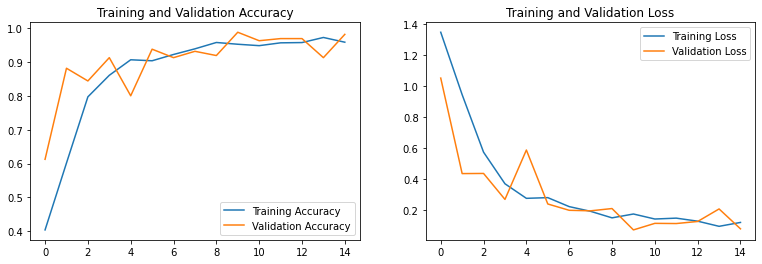

In [124]:
# Plot Accuracy and Loss CNN Model
import matplotlib.pyplot as plt
 
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(13, 4))
for i, metrics in enumerate(zip([acc, loss], [val_acc, val_loss], ['Accuracy', 'Loss'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
    plt.title('Training and Validation {}'.format(metrics[2]))
plt.show()

Saving hand.jpg to hand.jpg
hand.jpg
paper


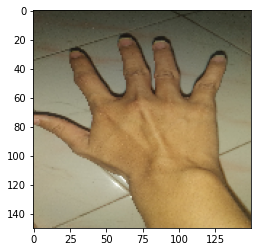

In [133]:
# predict images
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')